In [3]:
%matplotlib inline
from scipy.constants import zero_Celsius
import matplotlib.pyplot as plt
import numpy as np

from flask import Flask, render_template, request, jsonify



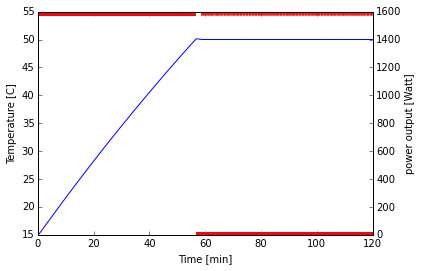

In [14]:
import pid

class model(object):
    def __init__(self, volume, heatpower, loss, roomtemp, T0):
        self.volume = volume
        self.heatpower = heatpower
        self.loss = loss
        self.roomtemp = roomtemp
        self.T = T0
        self.H0 = 0
        self.reaction = 0.05
        self.pid_value = 0
    def step(self, delta):
        E0 = self.volume*Cs*self.T
        self.H0 = self.H0 + self.reaction*(self.heatpower * self.pid_value - self.H0) * delta
        E1 = E0 + self.H0 * delta + self.loss * (self.roomtemp - self.T) * delta
        self.T = E1 / (Cs * self.volume)


temperatures = []
pid_out = []



t = np.linspace(0,120,120*60)

setpoint = 50
volume = 35 # kg
heatpower = 1600 # Watt
Cs = 4.1813e3 # J/(kg*K)
loss = 10 # W/K
roomtemp = 25 # C
T0 = 15 # C
m = model(volume, heatpower, loss, roomtemp, T0)
for i in t:
    m.step(1)
    temperatures.append(m.T)
    #pid_value = PID.calcPID_reg4(T, setpoint, True)
    if m.T > setpoint:
        m.pid_value = 0
    else:
        m.pid_value = 1
    pid_out.append(m.pid_value*heatpower)
    
plt.plot(t, np.array(temperatures))
plt.xlabel('Time [min]')
plt.ylabel('Temperature [C]')
plt.twinx()
plt.plot(t, pid_out, '|r')
plt.ylabel('power output [Watt]')



In [10]:
app = Flask(__name__, template_folder='templates')
#url_for('static', filename='raspibrew.css')

#Parameters that are used in the temperature control process
class param:
    status = {
        "numTempSensors" : 0,
        "temp" : "0",
        "tempUnits" : "F",
        "elapsed" : "0",
        "mode" : "off",
        "cycle_time" : 2.0,
        "duty_cycle" : 0.0,
        "boil_duty_cycle" : 60,
        "set_point" : 0.0,
        "boil_manage_temp" : 200,
        "num_pnts_smooth" : 5,
        "k_param" : 44,
        "i_param" : 165,
        "d_param" : 4             
    }


# main web page    
@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'GET':
        #render main page
        return render_template(template_name, mode = param.status["mode"], set_point = param.status["set_point"], \
                               duty_cycle = param.status["duty_cycle"], cycle_time = param.status["cycle_time"], \
                               k_param = param.status["k_param"], i_param = param.status["i_param"], \
                               d_param = param.status["d_param"])
        
    else: #request.method == 'POST' (first temp sensor / backwards compatibility)
        # get command from web browser or Android   
        #print request.form
        param.status["mode"] = request.form["mode"] 
        param.status["set_point"] = float(request.form["setpoint"])
        param.status["duty_cycle"] = float(request.form["dutycycle"]) #is boil duty cycle if mode == "boil"
        param.status["cycle_time"] = float(request.form["cycletime"])
        param.status["boil_manage_temp"] = float(request.form.get("boilManageTemp", param.status["boil_manage_temp"])) 
        param.status["num_pnts_smooth"] = int(request.form.get("numPntsSmooth", param.status["num_pnts_smooth"])) 
        param.status["k_param"] = float(request.form["k"])
        param.status["i_param"] = float(request.form["i"])
        param.status["d_param"] = float(request.form["d"])
                
        #send to main temp control process 
        #if did not receive variable key value in POST, the param class default is used
        parent_conn.send(param.status)  
        
        return 'OK'

#post params (selectable temp sensor number)    
@app.route('/postparams/<sensorNum>', methods=['POST'])
def postparams(sensorNum=None):
    
    param.status["mode"] = request.form["mode"] 
    param.status["set_point"] = float(request.form["setpoint"])
    param.status["duty_cycle"] = float(request.form["dutycycle"]) #is boil duty cycle if mode == "boil"
    param.status["cycle_time"] = float(request.form["cycletime"])
    param.status["boil_manage_temp"] = float(request.form.get("boilManageTemp", param.status["boil_manage_temp"])) 
    param.status["num_pnts_smooth"] = int(request.form.get("numPntsSmooth", param.status["num_pnts_smooth"]))
    param.status["k_param"] = float(request.form["k"])
    param.status["i_param"] = float(request.form["i"])
    param.status["d_param"] = float(request.form["d"])
            
    #send to main temp control process 
    #if did not receive variable key value in POST, the param class default is used
    if sensorNum == "1":
        print("got post to temp sensor 1")
        parent_conn.send(param.status)
    elif sensorNum == "2":
        print("got post to temp sensor 2")
        if len(pinHeatList) >= 2:
            parent_connB.send(param.status)
        else:
            param.status["mode"] = "No Temp Control"
            param.status["set_point"] = 0.0
            param.status["duty_cycle"] = 0.0 
            parent_connB.send(param.status)
            print("no heat GPIO pin assigned")
    elif sensorNum == "3":
        print("got post to temp sensor 3")
        if len(pinHeatList) >= 3:
            parent_connC.send(param.status)
        else:
            param.status["mode"] = "No Temp Control"
            param.status["set_point"] = 0.0
            param.status["duty_cycle"] = 0.0 
            parent_connC.send(param.status)
            print("no heat GPIO pin assigned")
    else:
        print("Sensor doesn't exist (POST)")
        
    return 'OK'

#post GPIO     
@app.route('/GPIO_Toggle/<GPIO_Num>/<onoff>', methods=['GET'])
def GPIO_Toggle(GPIO_Num=None, onoff=None):
    
    if len(pinGPIOList) >= int(GPIO_Num):
        out = {"pin" : pinGPIOList[int(GPIO_Num)-1], "status" : "off"}
        if onoff == "on":
            GPIO.output(pinGPIOList[int(GPIO_Num)-1], ON)
            out["status"] = "on"
            print("GPIO Pin #%s is toggled on" % pinGPIOList[int(GPIO_Num)-1]) 
        else: #off
            GPIO.output(pinGPIOList[int(GPIO_Num)-1], OFF)
            print("GPIO Pin #%s is toggled off" % pinGPIOList[int(GPIO_Num)-1]) 
    else:
        out = {"pin" : 0, "status" : "off"}
        
    return jsonify(**out)
    
#get status from RasPiBrew using firefox web browser (first temp sensor / backwards compatibility)
@app.route('/getstatus') #only GET
def getstatusB():          
    #blocking receive - current status    
    param.status = statusQ.get()        
    return jsonify(**param.status)

#get status from RasPiBrew using firefox web browser (selectable temp sensor)
@app.route('/getstatus/<sensorNum>') #only GET
def getstatus(sensorNum=None):          
    #blocking receive - current status
    if sensorNum == "1":
        param.status = statusQ.get()
    elif sensorNum == "2":
        param.status = statusQ_B.get()
    elif sensorNum == "3":
        param.status = statusQ_C.get()
    else:
        print("Sensor doesn't exist (GET)")
        param.status["temp"] = "-999"
        
    return jsonify(**param.status)

app.debug = True 
app.run(use_reloader=False)